# Taylor plots for comparing model and observation results

In this notebook, I'll show how we can create a Taylor diagram to summarize model performance using CESM2 and observed sea ice area as an example.

Observed sea ice area can be obtained from the NSIDC at [https://noaadata.apps.nsidc.org/NOAA/G02135/north/](https://noaadata.apps.nsidc.org/NOAA/G02135/north/). 

We'll start by reading in the data and correcting some differences in the time index - both are monthly averages, but one placed the time index at the middle of the month and the other doesn't provide a day, so we set both for Day 1.

Other methods for Taylor diagram plotting: https://projectpythia.org/advanced-viz-cookbook/notebooks/4-taylor-diagrams.html


In [1]:
import pandas as pd
import proplot as pplt
import numpy as np
import os

In [2]:
df_model = pd.read_csv('../UTRA/siarea_csv/cmip6.historical.CESM2.siarea.csv', 
                parse_dates=['time'])
df_model.index = pd.to_datetime({'year': df_model['time'].dt.year,
                                 'month': df_model['time'].dt.month,
                                 'day': 1})
df_model.drop('time', axis=1, inplace=True)
df_model /= 1e12 # convert units

In [3]:
df_obs = []
# load the time series for indivual months
for file in os.listdir('data_nsidc'):
    if '.csv' in file:
        df_obs.append(pd.read_csv('data_nsidc/' + file))
df_obs = pd.concat(df_obs)
df_obs.columns = ['year', 'month', 'data-type', 'region', 'extent', 'area']

# fill a few missing spots via interpolation
df_obs['area'] = df_obs['area'].where(df_obs['area'] > 0).interpolate()

# build the index
df_obs.index = pd.to_datetime({'year': df_obs['year'],
                                 'month': df_obs['month'],
                                 'day': 1})
df_obs.sort_index(inplace=True)

# limit to the period with the model data
df_obs = df_obs.loc[slice('1979-01-01', '2014-12-01')]

In [4]:
df_obs.head()



,year,month,data-type,region,extent,area
1979-01-01,1979,1,Goddard,N,15.41,12.41
1979-02-01,1979,2,Goddard,N,16.18,13.18
1979-03-01,1979,3,Goddard,N,16.34,13.21
1979-04-01,1979,4,Goddard,N,15.45,12.53
1979-05-01,1979,5,Goddard,N,13.86,11.11


In [5]:
df_obs.index = pd.to_datetime({'year': df_obs['year'],
                                 'month': df_obs['month'],
                                 'day': 1})
df_obs.sort_index(inplace=True)

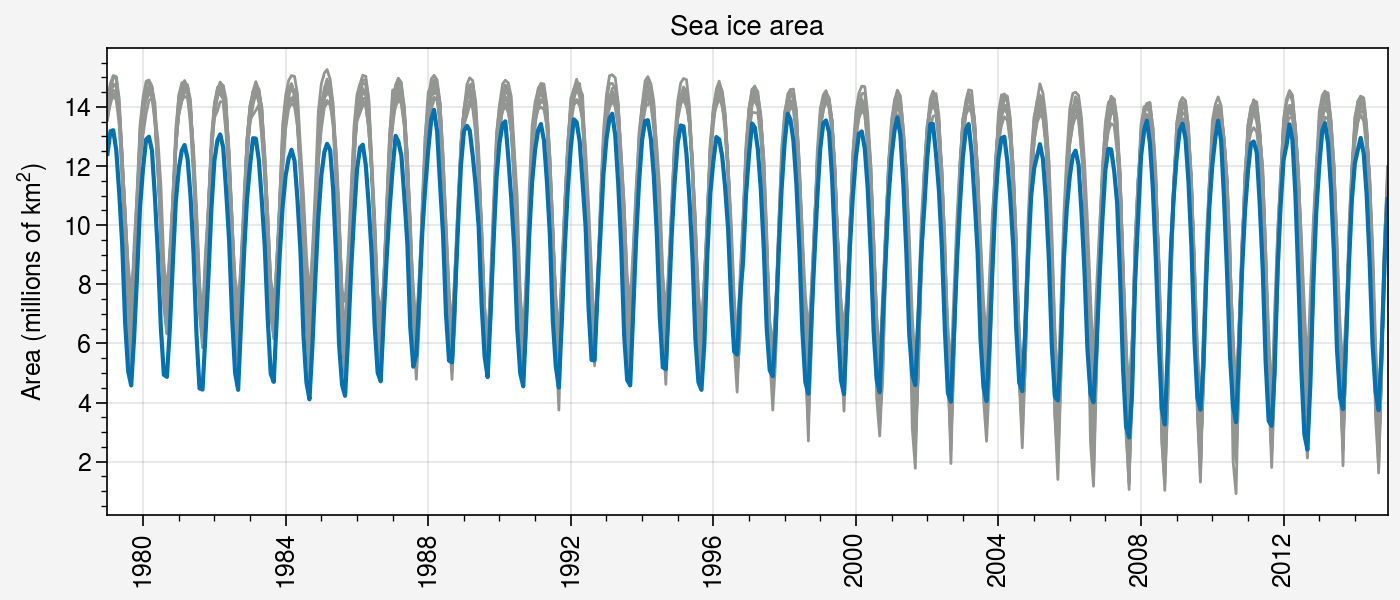

In [6]:
fig, ax = pplt.subplots(width=7, height=3)

for ens in df_model.columns:
    # Divide by 1e12 to convert to the same units
    ax.plot(df_model[ens], color='gray', lw=1)
ax.plot(df_obs['area'])    
ax.format(title='Sea ice area', ylabel='Area (millions of km$^2$)')

All right! We can see that the CESM2 output has similar variability but tends to have some biases towards too-high winter ice area and too-low summer ice area.

In [7]:
from scipy.signal import detrend

In [15]:
# Take out the monthly mean
df_model_anom = df_model - df_model.groupby(df_model.index.month).transform('mean')

# Then detrend:
for ens in df_model_anom:
    df_model_anom[ens] = detrend(df_model_anom[ens])

In [14]:
# And the same for the observations
df_obs_anom = df_obs['area'] - df_obs['area'].groupby(df_obs.index.month).transform('mean')
t = df_obs_anom.index
df_obs_anom = pd.Series(detrend(df_obs_anom), index=t)

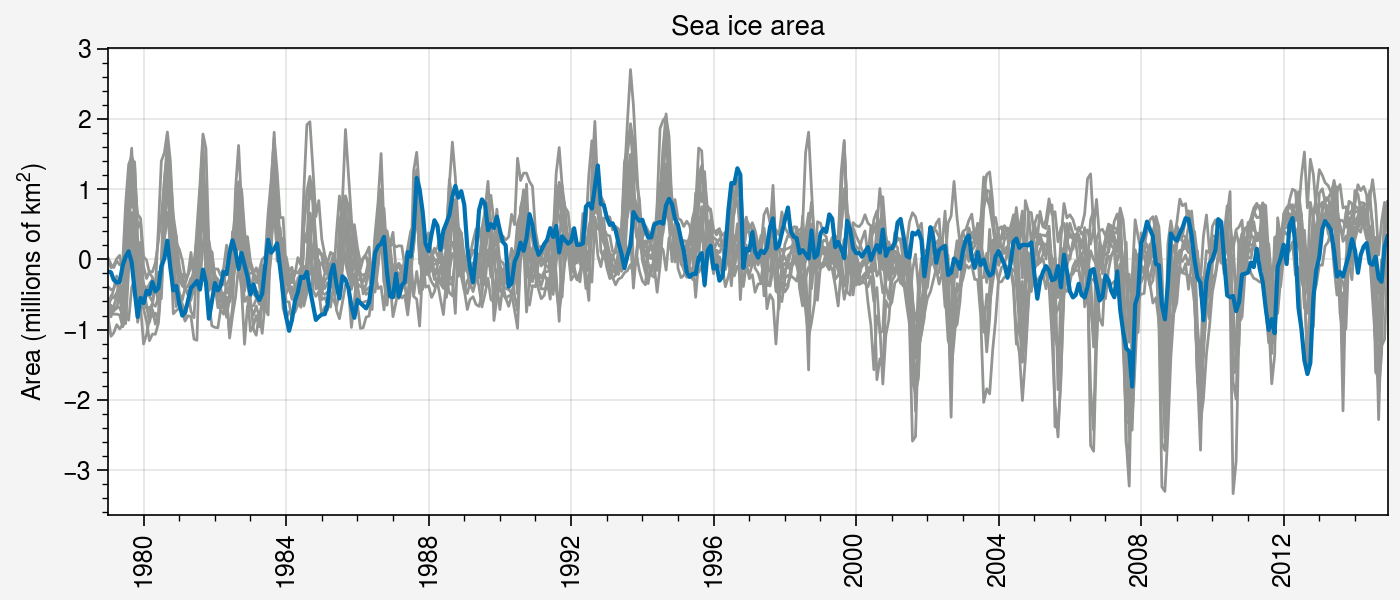

In [16]:
fig, ax = pplt.subplots(width=7, height=3)

for ens in df_model.columns:
    # Divide by 1e12 to convert to the same units
    ax.plot(df_model_anom[ens], color='gray', lw=1)
ax.plot(df_obs_anom)    
ax.format(title='Sea ice area', ylabel='Area (millions of km$^2$)')

In [11]:
import matplotlib.pyplot as plt

Example 1: Using detrended, deseasonalized data, and using non-normalized standard deviation

/opt/homebrew/Caskroom/miniconda/base/envs/cmip6/lib/python3.9/site-packages/matplotlib/ticker.py:2938: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


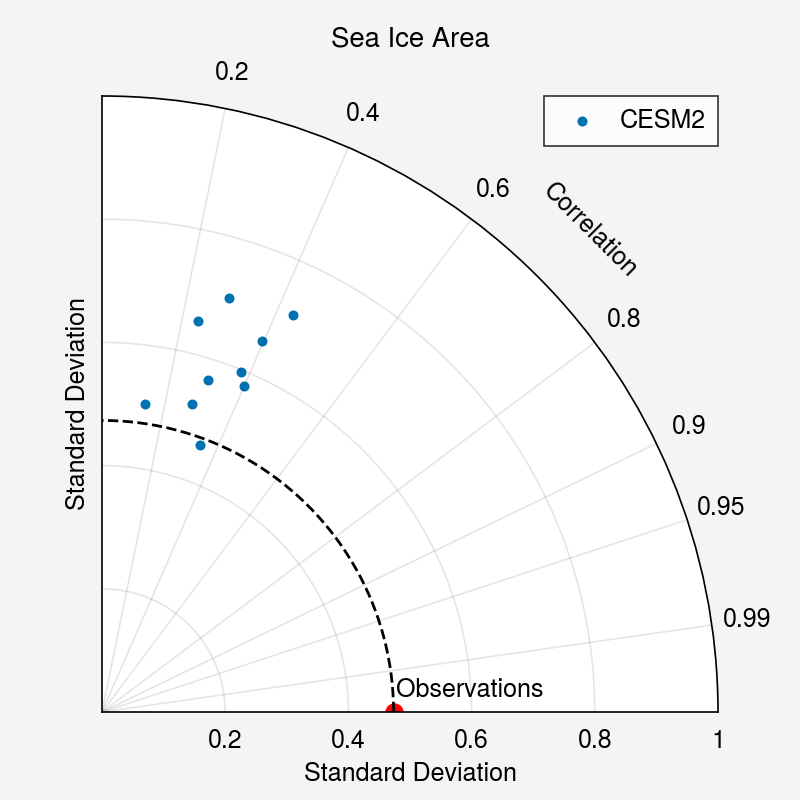

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
obs_stdev = df_obs_anom.std()
R = [df_obs_anom.corr(df_model_anom[ens]) for ens in df_model_anom]
model_stdev = df_model_anom.std(axis=0)

c = ax.scatter(np.arccos(R), model_stdev, alpha=1, marker='.', label='CESM2')
th = np.linspace(0, np.pi/2)
ax.plot(th, np.ones(th.size)*obs_stdev, ls='--', color='k', lw=1)
ax.scatter(0, obs_stdev, marker='o', color='r')
ax.text(0.05, obs_stdev*1.01, 'Observations')

# Adjust figure properties and range
ax.set_thetamin(0)
ax.set_thetamax(90)
ax.set_rmax(1)
ax.set_xlabel('Standard Deviation', labelpad=18)
ax.set_ylabel('Standard Deviation')
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
corr_labels = [str(x) for x in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]]
theta_labels = [np.rad2deg(np.arccos(x)) for x in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]]
_ = ax.set_thetagrids(angles=theta_labels, labels=corr_labels)
ax.text(np.pi/4, 1, 'Correlation', rotation=-45)
ax.set_title("Sea Ice Area")
ax.legend()

Example 2: Not detrending (so simulataneously comparing seasonality and trends), and dividing by the standard deviation of the observations.

/opt/homebrew/Caskroom/miniconda/base/envs/cmip6/lib/python3.9/site-packages/matplotlib/ticker.py:2938: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


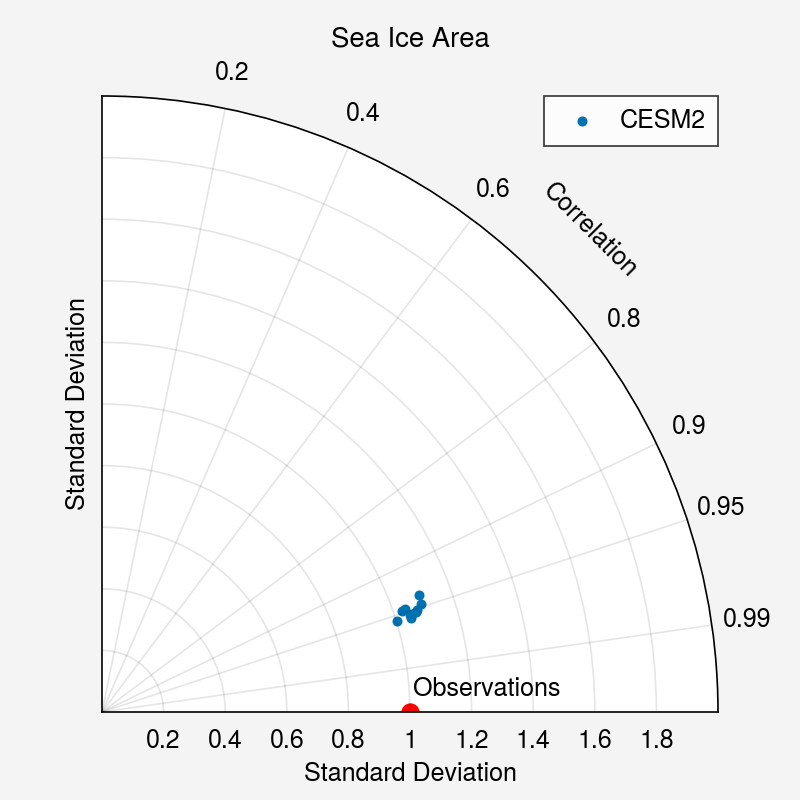

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
obs_stdev = df_obs['area'].std()
R = [df_obs['area'].corr(df_model[ens]) for ens in df_model_anom]
model_stdev = df_model.std(axis=0)/obs_stdev

c = ax.scatter(np.arccos(R), model_stdev.values, alpha=1, marker='.', label='CESM2')
th = np.linspace(0, np.pi/2)
ax.plot(th, np.ones(th.size)*obs_stdev, ls='--', color='k', lw=1)
ax.scatter(0, 1, marker='o', color='r')
ax.text(0.05, 1.01, 'Observations')

# Adjust figure properties and range
ax.set_thetamin(0)
ax.set_thetamax(90)
ax.set_rmax(2)
ax.set_xlabel('Standard Deviation', labelpad=18)
ax.set_ylabel('Standard Deviation')
ax.set_yticks(np.linspace(0.2, 1.8, 9))
corr_labels = [str(x) for x in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]]
theta_labels = [np.rad2deg(np.arccos(x)) for x in [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]]
_ = ax.set_thetagrids(angles=theta_labels, labels=corr_labels)
ax.text(np.pi/4, 2, 'Correlation', rotation=-45)
ax.set_title("Sea Ice Area")
ax.legend()